<a href="https://colab.research.google.com/github/swtguha/Recommendation-System/blob/main/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/ratings_small.csv"
file_path1 = "/content/drive/My Drive/movies_metadata.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
# Data manipulation
import pandas as pd

# Feature extraction and similarity computation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Numerical computation (if needed)
import numpy as np

# Visualization (optional)
import matplotlib.pyplot as plt

In [93]:
df1 = pd.read_csv(file_path)
df2 = pd.read_csv(file_path1)

<ipython-input-93-7a69ffc728dd>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(file_path1)


In [94]:
#Data pre-processing for rating_small csv
missingValues = df1.isnull().sum()

# Calculate the percentage of missing values for each column
missing_percentage = (missingValues / len(df1)) * 100

# Combine missing values and percentage into a DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Values': missingValues,
    'Percentage (%)': missing_percentage
})

# Display the summary
print(missing_summary)




           Missing Values  Percentage (%)
userId                  0             0.0
movieId                 0             0.0
rating                  0             0.0
timestamp               0             0.0


In [95]:
# Identify categorical columns
categorical_cols = df2.select_dtypes(include=['object', 'category']).columns

# Identify numeric columns
numeric_cols = df2.select_dtypes(include=['number']).columns




# Check missing values in categorical columns
missing_values_categorical = df2[categorical_cols].isnull().sum()
print("Missing values in categorical columns:")
print(missing_values_categorical)

Missing values in categorical columns:
adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
dtype: int64


In [96]:
print(df2['popularity'].dtype)
print(df2['popularity'].head(5))

object
0    21.946943
1    17.015539
2      11.7129
3     3.859495
4     8.387519
Name: popularity, dtype: object


In [97]:
# Convert 'popularity' to numeric, coercing errors to NaN
df2['popularity'] = pd.to_numeric(df2['popularity'], errors='coerce')

In [98]:
df2['belongs_to_collection'].fillna('Unknown', inplace=True)
df2['homepage'].fillna('Unknown', inplace=True)
df2['tagline'].fillna('Unknown', inplace=True)
df2['overview'].fillna('No Overview', inplace=True)
df2['poster_path'].fillna('Unknown', inplace=True)
# Fill missing values in 'popularity' with the median value
df2['popularity'].fillna(df2['popularity'].median(), inplace=True)

# Fill missing values in production_companies and production_countries with 'Unknown'
df2['production_companies'].fillna('Unknown', inplace=True)
df2['production_countries'].fillna('Unknown', inplace=True)

# Fill missing values in release_date with a placeholder (e.g., 'Unknown' or a default date)
df2['release_date'].fillna('Unknown', inplace=True)

# Fill missing values in spoken_languages with 'Unknown'
df2['spoken_languages'].fillna('Unknown', inplace=True)

# Fill missing values in status with 'Unknown'
df2['status'].fillna('Unknown', inplace=True)

# Fill missing values in title and video with 'Unknown'
df2['title'].fillna('Unknown', inplace=True)
df2['video'].fillna('Unknown', inplace=True)

# Remove rows with missing values in critical columns if necessary
df2.dropna(subset=['imdb_id', 'original_language'], inplace=True)


In [99]:
# Check missing values in categorical columns
missing_values_categorical = df2[categorical_cols].isnull().sum()
print("Missing values in categorical columns:")
print(missing_values_categorical)

Missing values in categorical columns:
adult                    0
belongs_to_collection    0
budget                   0
genres                   0
homepage                 0
id                       0
imdb_id                  0
original_language        0
original_title           0
overview                 0
popularity               0
poster_path              0
production_companies     0
production_countries     0
release_date             0
spoken_languages         0
status                   0
tagline                  0
title                    0
video                    0
dtype: int64


In [100]:
# Sample a subset of 5000 movies
sample_size = 5000
df2_sampled = df2.sample(n=sample_size, random_state=42)
df2_sampled.reset_index(drop=True, inplace=True)
print(df2_sampled["id"].head(5))

0     21585
1    254320
2     12163
3     32834
4     74237
Name: id, dtype: object


In [101]:
print(df2_sampled.shape)

(5000, 24)


In [102]:
print(df2_sampled.head(5))

   adult                              belongs_to_collection   budget  \
0  False                                            Unknown        0   
1  False                                            Unknown  4000000   
2  False                                            Unknown  6000000   
3  False  {'id': 368982, 'name': 'MVP', 'poster_path': '...        0   
4  False                                            Unknown        0   

                                              genres  \
0                     [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 53, 'name': 'Thriller'}, {'id': 35, 'n...   
2  [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...   
3  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
4  [{'id': 99, 'name': 'Documentary'}, {'id': 104...   

                                            homepage      id    imdb_id  \
0                                            Unknown   21585  tt0195691   
1  http://tickets.picturehouseentertainment.co.uk...  254320  tt3464902   
2    

In [103]:
#Feature Extraction

from sklearn.feature_extraction.text import TfidfVectorizer

# Extract features from the overview text
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df2_sampled['overview'])
print(tfidf_matrix.shape)

(5000, 24617)


In [104]:


# Extract genres features
# Convert genres to a list of lists
df2_sampled['genres'] = df2_sampled['genres'].apply(lambda x: x.split('|'))

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genres_matrix = mlb.fit_transform(df2_sampled['genres'])

In [105]:
#Feature Combination

from scipy.sparse import hstack

# Combine text features and genres features
features_matrix = hstack([tfidf_matrix, genres_matrix])

In [106]:
#Similarity Calculation
from sklearn.metrics.pairwise import cosine_similarity


# Compute similarity matrix on reduced dimensions
cosine_sim= cosine_similarity(features_matrix, features_matrix)
print(cosine_sim.shape)
print(cosine_sim)

(5000, 5000)
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.5        0.         0.        ]
 ...
 [0.         0.         0.5        ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.01403677]
 [0.         0.         0.         ... 0.         0.01403677 1.        ]]


In [107]:
print("Columns in df2_sampled:", df2_sampled.columns)

Columns in df2_sampled: Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


In [108]:
# Construct a reverse map of indices and movie titles
indices = pd.Series(df2_sampled.index, index=df2_sampled['original_title']).drop_duplicates()
print(indices.head(5))

def get_movie_id_from_title(title, indices):
    """
    Get the movie index for a given movie title using the reverse map.

    Parameters:
    - title: Title of the movie
    - indices: Series mapping movie titles to their indices

    Returns:
    - Index of the movie if found, else None
    """


    # Check if the title exists in the indices and return the corresponding index
    if title in indices:
        return indices[title]
    else:
        return None

original_title
Robin Williams: An Evening with Robin Williams    0
The Lobster                                       1
The Wrestler                                      2
MVP: Most Valuable Primate                        3
A Skin Too Few: The Days of Nick Drake            4
dtype: int64


In [109]:
def compute_similarity_scores(cosine_sim, top_n: int=10):
    # Get similarity scores for the movie
    sim_scores = list(enumerate(cosine_sim))

    # Sort movies based on similarity scores and get the top N similar movies
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # Exclude the movie itself and get top N
    return sim_scores

def get_recommendations_by_title(title, df2_sampled, cosine_sim, indices, top_n: int=10):
    """
    Get top N movie recommendations based on cosine similarity using movie title.

    Parameters:
    - title: Title of the movie for which recommendations are to be generated
    - df2_sampled: DataFrame containing the sampled movies
    - cosine_sim: Cosine similarity matrix
    - indices: Series mapping movie titles to their indices
    - top_n: Number of top recommendations to return

    Returns:
    - DataFrame with recommended movies
    """
    idx = get_movie_id_from_title(title, indices)
    print(idx)

    if idx is None:
        print(f"Movie '{title}' not found in the dataset.")
        return pd.DataFrame()

    # Validate index
    if idx >= cosine_sim.shape[0]:
        print(f"Index {idx} is out of bounds for the similarity matrix with size {cosine_sim.shape[0]}.")
        return pd.DataFrame()

    # Get similarity scores for the movie
    sim_scores = compute_similarity_scores(cosine_sim=cosine_sim[idx], top_n=top_n)

    # Get movie indices from similarity scores
    movie_indices = [i[0] for i in sim_scores]

    # Check if indices are within bounds
    valid_indices = [i for i in movie_indices if i < cosine_sim.shape[0]]
    if not valid_indices:
        print("No valid movie indices found for recommendations.")
        return pd.DataFrame()

    # Return the top N most similar movies
    return df2_sampled[['original_title', 'genres']].iloc[valid_indices]

# Example usage
movie_title_example = 'Robin Williams: An Evening with Robin Williams'
recommended_movies = get_recommendations_by_title(movie_title_example, df2_sampled, cosine_sim, indices)
print(recommended_movies)

# print(f"Size of DataFrame: {df2_sampled.shape}")
# print(f"Size of Similarity Matrix: {cosine_sim.shape}")
# print(f"Size of Indices Series: {indices.shape}")

0
                          original_title                            genres
1627  Robin Williams: A Night at the Met  [[{'id': 35, 'name': 'Comedy'}]]
520        Chris Gethard: Career Suicide  [[{'id': 35, 'name': 'Comedy'}]]
2304                 Eddie Izzard: Sexie  [[{'id': 35, 'name': 'Comedy'}]]
3403                    Thou Shalt Laugh  [[{'id': 35, 'name': 'Comedy'}]]
363                    A Flea In Her Ear  [[{'id': 35, 'name': 'Comedy'}]]
4008      Thou Shalt Laugh 2 - The Deuce  [[{'id': 35, 'name': 'Comedy'}]]
1471                       Hollidaysburg  [[{'id': 35, 'name': 'Comedy'}]]
4787                Zhenitba Balzaminova  [[{'id': 35, 'name': 'Comedy'}]]
4528     Amy Schumer: Live at the Apollo  [[{'id': 35, 'name': 'Comedy'}]]
1925                 Chlopaki nie placza  [[{'id': 35, 'name': 'Comedy'}]]


In [110]:
print(df1['rating'].describe())
print(df1['userId'].nunique())  # Number of unique users
print(df1['movieId'].nunique())  # Number of unique movies

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64
671
9066


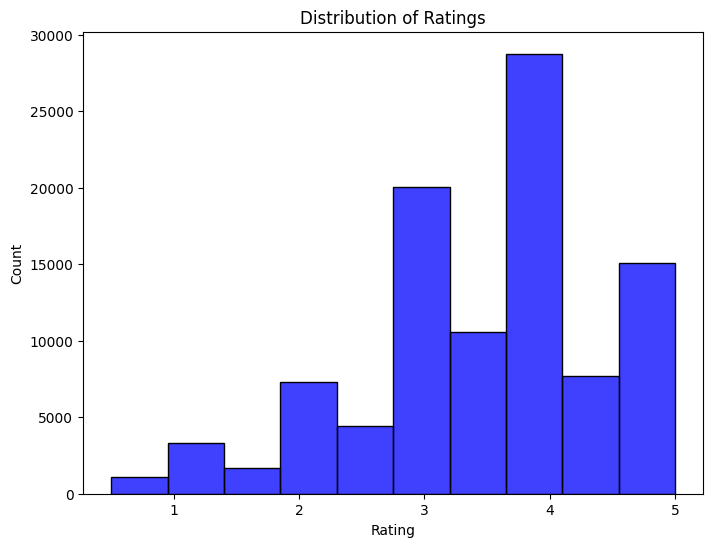

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot rating distribution
plt.figure(figsize=(8, 6))
sns.histplot(df1['rating'], bins=10, kde=False, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [112]:
print(df2_sampled.columns)

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')
